In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [2]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3,dirichlet, neumann

In [3]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [4]:
def delta_n(i,x,y,alpha,elements):
    indice_i_1 = np.where(elements == i)[0][0]+1
    if(indice_i_1 == 3):
        indice_i_1 = 0
    indice_i_2 = np.where(elements == i)[0][0]+2
    if(indice_i_2 == 3):
            indice_i_2 = 0
    if(indice_i_2 == 4):
            indice_i_2 = 1 
    return np.array([[1/alpha*(y[indice_i_1]-y[indice_i_2])],[1/alpha*(x[indice_i_2]-x[indice_i_1])]])

In [5]:
def f(x,y):
    return 1

In [6]:
def ud(x,y):
    return 1

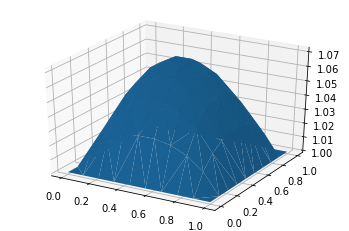

In [7]:
def Assemblage_triangulaire(m,f,ud):
    [coordinates,elements3,dirichlet,_] = maillage(m);
    n = len(coordinates)
    A = np.zeros([n,n]);
    b = np.zeros([n,1])
    Ud = np.zeros([n,1])
    Nt = len(elements3)
    for p in dirichlet:
        Ud[p,0] = ud(coordinates[p,0],coordinates[p,1])
    for k in range (Nt):
        x = coordinates[elements3[k],0]
        y = coordinates[elements3[k],1]
        alpha = np.linalg.det(np.array([[x[1]-x[0],x[2]-x[0]],[y[1]-y[0],y[2]-y[0]]]))
        for i in elements3[k]:
            for j in elements3[k]:
                delta_ni = delta_n(i,x,y,alpha,elements3[k])
                delta_nj = delta_n(j,x,y,alpha,elements3[k])
                A[i][j] = A[i][j] + alpha /2 * np.dot(np.transpose(delta_ni),delta_nj)[0][0]
        xg = x.mean()
        yg = y.mean()
        for i in elements3[k]:
            b[i] = b[i]+alpha/6*f(xg,yg)

    b = b-np.dot(A,Ud)
    indices = np.array([[i] for i in range(n)])
    indices_choisis = np.setdiff1d(indices,dirichlet)
    A_telda_1 = A[indices_choisis]
    A_telda = A_telda_1[:,indices_choisis]
    b_telda = b[indices_choisis]
    u_telda = np.linalg.solve(A_telda,b_telda)
    u = Ud
    u[indices_choisis] = u_telda
    return A_telda,coordinates,u.flatten()
    
A,ccs,u = Assemblage_triangulaire(10,f,ud)
show(ccs,u)

**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [8]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

In [9]:
def g(x,y):
    return 1

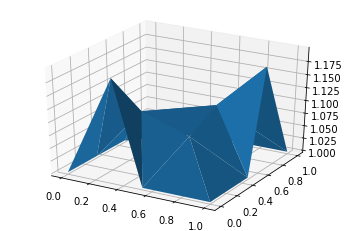

In [10]:
n = len(ccs)
A = np.zeros([n,n])
B = np.zeros([n,1])
Ud = np.zeros([n,1])
Nt = len(e3)
Nq = len(e4)
for p in dds:
    Ud[p,0] = ud(ccs[p,0],ccs[p,1])
for k in range (Nt):
    x = ccs[e3[k],0]
    y = ccs[e3[k],1]
    alpha = np.linalg.det(np.array([[x[1]-x[0],x[2]-x[0]],[y[1]-y[0],y[2]-y[0]]]))
    for i in e3[k]:
        for j in e3[k]:
            delta_ni = delta_n(i,x,y,alpha,e3[k])
            delta_nj = delta_n(j,x,y,alpha,e3[k])
            A[i][j] = A[i][j] + alpha /2 * np.dot(np.transpose(delta_ni),delta_nj)[0][0]
    xg = x.mean()
    yg = y.mean()
    for i in e3[k]:
        B[i] = B[i]+alpha/6*f(xg,yg)
    
    
for k in range (Nq):
    x = ccs[e4[k],0]
    y = ccs[e4[k],1]
    jacobien = np.array([[x[1]-x[0],x[3]-x[0]],[y[1]-y[0],y[3]-y[0]]])
    determinant = np.linalg.det(jacobien)
    J = np.linalg.inv(np.dot(np.transpose(jacobien),jacobien))
    a = J[0][0]
    b = J[0][1]
    c = J[1][1]
    M = np.zeros([4,4])
    M[0][0] = determinant/6*(2*a+3*b+2*c)
    M[0][1] = determinant*(c/6-a/3)
    M[0][2] = determinant*(-c/6-b/2-a/6)
    M[0][3] = determinant*(-c/3+a/6)
    M[1][1] = determinant*(-b/2+c/3+a/3)
    M[1][2] = determinant*(-c/3+a/6)
    M[1][3] = determinant*(-c/6+b/2-a/6)
    M[2][2] = determinant/6*(2*a+3*b+2*c)
    M[2][3] = determinant*(c/6-a/3)
    M[3][3] = determinant*(c/3+a/3-b/2)
    M[1][0] = M[0][1]
    M[2][0] = M[0][2]
    M[3][0] = M[0][3]
    M[2][1] = M[1][2]
    M[3][1] = M[1][3]
    M[3][2] = M[2][3]
    p = 0
    for i in e4[k]:
        l = 0
        for j in e4[k]:
            A[i][j] = A[i][j] + M[p][l]
            l = l +1
        p = p +1
    
    xg = x.mean()
    yg = y.mean()
    for i in e4[k]:
        B[i] = B[i]+determinant/4*f(xg,yg)
        
B = B-np.dot(A,Ud)

for k in range (len(nns)):
    indice1 = nns[k][0]
    indice2 = nns[k][1]
    x1 = ccs[indice1,0]
    x2 = ccs[indice2,0]
    y1 = ccs[indice1,1]
    y2 = ccs[indice2,1]
    xm = (x1+x2)/2
    ym = (y1+y2)/2
    longueur = np.linalg.norm(np.array([[x2-x1],[y2-y1]]), ord=2)
    B[indice1] = B[indice1]+1/2*longueur*g(xm,ym)
    B[indice2] = B[indice2]+1/2*longueur*g(xm,ym)


indices = np.array([[i] for i in range(n)])
indices_choisis1 = np.setdiff1d(indices,dds)
A_telda_1 = A[indices_choisis1]
A_telda = A_telda_1[:,indices_choisis1]
b_telda = B[indices_choisis1]
u_telda = np.linalg.solve(A_telda,b_telda)
u = Ud
u[indices_choisis1] = u_telda
show(ccs,u.flatten())
        

**Compléments d'analyse du système**

In [11]:
def u_ex(x,y):
    return math.sin(math.pi*x)*math.sin(math.pi*y)

In [12]:
def f_complement(x,y):
    return 2*math.pi*math.sin(math.pi*x)*math.sin(math.pi*y)

In [13]:
def ud_complement(x,y):
    return 0

l'ordre de discrétisation est :  2


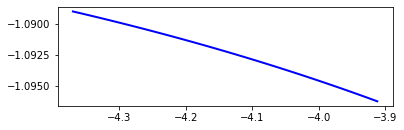

In [22]:
nbpoints = 80
M = range(50,nbpoints)
longueur = len(M)
h = [1/i for i in M]
#np.linspace(1/nbpoints,0.1,nbpoints)
def norm_h(m,h):
    A,ccs,uh = Assemblage_triangulaire(m,f_complement,ud_complement)
    u = np.array([u_ex(ccs[i][0],ccs[i][1]) for i in range(len(ccs))])
    return h*np.linalg.norm(u-uh)

difference = [norm_h(j,1/j) for j in M]
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

hlog = [math.log(i) for i in h]
differencelog = [math.log(i) for i in difference]
line, = ax.plot(hlog,differencelog, color='blue', lw=2)

pente, intercept = np.polyfit(hlog,differencelog,1)
print("l'ordre de discrétisation est : ",-math.floor(pente)+1)


la pente de la droite est :  2


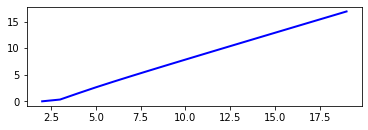

In [19]:
N = range(2,20)
def Rnonnul(n):
    A,ccs,u = Assemblage_triangulaire(n,f_complement,ud_complement)
    R = np.linalg.cholesky(A)
    return len(np.where(R != 0)[0])/(A.shape[0]^2)

def RatioNonnul(n):
    A,ccs,u = Assemblage_triangulaire(n,f_complement,ud_complement)
    R = np.linalg.cholesky(A)
    return len(np.where(R != 0)[0])/len(np.where(A != 0)[0])

NNs = [Rnonnul(i) for i in N]

#RNs = [RatioNonnul(i) for i in N]

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(N,NNs, color='blue', lw=2)
#line2, = ax.plot(N,RNs, color='red', lw=2)

pente, intercept = np.polyfit(N,NNs,1)
print("la pente de la droite est : ",math.floor(pente)+1)

#calculer le ratio entre le nombre de non nul dans R et celui de A et voir la vitesse,  